# Project: Understanding the Intrinsic and Extrinsic Value of Options Premium
The premium that a buyer of an American options contract pays $\mathcal{P}$ is composed of two components, the `intrinsic` value $\mathcal{P}_{int}$ and `extrinsic` value $\mathcal{P}_{ext}$:
* The `intrinsic` value $\mathcal{P}_{int}$ of the options premium is the value of the option contract if exercised now, i.e., it is the current payoff of the contract. Thus, the intrinsic value will be a function of the scaled strike price $K/S_{\circ}$. However, the intrinsic value will not be a _direct_ function of the time to expiration.
* The `extrinsic` value $\mathcal{P}_{ext}$ is the difference between the current premium $\mathcal{P}$ and the intrinsic value, i.e., $\mathcal{P}_{ext} = \mathcal{P} - \mathcal{P}_{int}$. As the days to expiration `DTE` of the options contract approaches zero, the `extrinsic` value approaches zero, i.e., $\lim_{DTE\rightarrow{0}}\,\mathcal{P}_{ext}\rightarrow{0}$. Thus, the extrinsic value will be a function of the scaled strike price $K/S_{\circ}$ (through the intrinsic value) and the days to expiration (through the premium).

## Learning tasks
This project aims to familiarize students with understanding option contracts `intrinsic` and `extrinsic` values and to help them consider what factors control each.

* __Prerequisites__: load and interrogate the options chains for different values of the days to expiration (DTE) parameter for an example underlying ticker, in this case, [Advanced Micro Devices](https://finance.yahoo.com/quote/AMD/) with the ticker symbol `AMD.`
* __Task 1__: Compute the Intrinsic and Extrinsic values of American put contacts. In this task, we will compute the intrinsic and extrinsic values of an `AMD` put contract with `DTE` days to expiration (where `DTE` was specified above) using our market dataset. We'll show that the intrinsic and extrinsic values change as a function of the scaled strike price $K/S_{\circ}$.
* __Task 2__: Compute the Intrinsic and Extrinsic values of American call contacts. In this task, we will compute the intrinsic and extrinsic values of an `AMD` call contract with `DTE` days to expiration (where `DTE` was specified above) using our market dataset. We'll show that the intrinsic and extrinsic values change as a function of the scaled strike price $K/S_{\circ}$.

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites
Load the options chain dataset using the `MyOptionsChainDataSet()` function. This function returns the pricing data as a [Julia Dictionary type](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) with `keys` holding the number of days to expiration `DTE::Int64` and `values` being a [Vector](https://docs.julialang.org/en/v1/base/arrays/#Base.Vector-Tuple{UndefInitializer,%20Any}) of multilevel dictionaries. We'll store the options contract price data in the `dataset` variable.
* In this project, we'll use options pricing data for [Advanced Micro Devices](https://finance.yahoo.com/quote/AMD/) as the underlying asset. The `dataset` variable holds pricing information for `call` and `put` contracts. Each contract has a different strike price. In addition to the contract price, there is additional information about the underlying asset and contract. 
* For any given `DTE` key, the price data is organized as a `Vector{Dict{String, Any}},` where each element in the vector is a dictionary with the `keys`: `day,` `details,` `last_quote,` `last_trade,` `underlying_asset,` `open_interest` and `break_even_price.` Each key (except for the `open_interest` and `break_even_price` keys) points to another dictionary.
* Finally, we populate lists of `call` and `put` options in the `list_of_put_options_chains` and `list_of_call_options_chains` variables, which have the type `Dict{Int64, DataFrame},` using the `search(...)` function.

In [5]:
dataset = MyOptionsChainDataSet(Date("2023-06-19"));

Let's populate a list of `put` and `call` options written against `AMD`  whose strike price is between `60` and `180` USD/share. We store these lists in the `list_of_put_options_chains` and `list_of_call_options_chains,` which have the type `Dict{Int64, DataFrame}.`

* __Put options__: `Unhide` the code block below to see how we populate a list of `put` options with strike prices between `60.0 ≤ K ≤ 180.0` in the `list_of_put_options_chains` variable

In [7]:
list_of_put_options_chains = Dict{Int64,DataFrame}();
DTEs = keys(dataset) |> collect |> sort;
for dte_value ∈ DTEs
    search(dataset, dte_value, (DTE::Int64, record::Dict{String, Any}) -> begin
            K = record["details"]["strike_price"]; # strike for this contract
            if (record["details"]["contract_type"] == "put" && 60.0 ≤ K ≤ 180.0)
                return true
            end
            return false
        end
    ) |> dataframe -> list_of_put_options_chains[dte_value] = dataframe;
end

* __Call options__: `Unhide` the code block below to see how we populate a list of `call` options with strike prices between `60.0 ≤ K ≤ 180.0` in the `list_of_call_options_chains` variable

In [9]:
list_of_call_options_chains = Dict{Int64,DataFrame}();
DTEs = keys(dataset) |> collect |> sort;
for dte_value ∈ DTEs
    search(dataset, dte_value, (DTE::Int64, record::Dict{String, Any}) -> begin
            K = record["details"]["strike_price"]; # strike for this contract
            if (record["details"]["contract_type"] == "call" && 60.0 ≤ K ≤ 180.0)
                return true
            end
            return false
        end
    ) |> dataframe -> list_of_call_options_chains[dte_value] = dataframe;
end

### Constants
Finally, let's set some constants we'll need for the rest of the project. The time step size `Δt::Float64` will be `1 calendar day`, the days to expiration `DTE` will be `39-days`, and we'll simulate a range of underlying prices from $S_{1}\rightarrow{S}_{2}$ in steps of `1-USD/share`. Finally, we set the `number_of_prices::Int64` variable, which holds the number of underlying prices we will use below. 

In [11]:
Δt = (1/365);
DTE = 39;
S₁ = 60.0;
S₂ = 180.0;
S = range(S₁, stop = S₂, step=1.0) |> collect;
number_of_prices = length(S);

## Task 1: Compute the Intrinsic and Extrinsic values of American put contacts
In this task, we will compute the intrinsic and extrinsic values of an `AMD` put contract with `DTE` days to expiration (where `DTE` was specified above) using our market dataset. We'll show that the intrinsic and extrinsic values change as a function of the scaled strike price $K/S_{\circ}$. For a `put` contract:
* When $K/S_{\circ}\leq{1}$, the `put` contract's intrinsic value is zero. Any non-zero premium observed in the marketplace is composed of only extrinsic value. In other words, if the `put` contract were to be exercised now, it would be worthless. However, buyers are willing to pay a non-zero premium for a seemingly worthless contract because they believe market conditions will change such that $K/S(T)>1$ at some `T` in the future (at which point the contract will no longer be worthless if exercised).
* When $K/S_{\circ}>{1}$, the premium observed in the marketplace will be a combination of extrinsic and intrinsic value. The contract has some value if exercised now, whereas the remainder of the observed premium consists of extrinsic value. The higher the `DTE,` the more the extrinsic value. As $K/S_{\circ}\rightarrow\infty$, the contract will have an increasing fraction of intrinsic value.

Let's start to explore these scenarios by selecting the `DTE` contracts in the `list_of_put_options_chains::Dict{Int64, DataFrame}` variable, which we'll store in the `tmp_put_contract_list::DataFrame` variable. Each row in `tmp_put_contract_list::DataFrame` corresponds to a different `put` contract with the same days to expiration `DTE` value but different strike prices $K$.

In [13]:
tmp_put_contract_list = list_of_put_options_chains[DTE]

Row,underlying,strike,type,bid,ask,midpoint,bid_size,ask_size
,Float64,Float64,String,Float64,Float64,Float64,Int64,Int64
1,119.62,180.0,put,58.1,60.65,59.375,1,1
2,119.62,175.0,put,52.75,55.8,54.275,10,15
3,119.62,170.0,put,48.0,50.85,49.425,1,1
4,119.62,165.0,put,42.9,46.1,44.5,10,16
5,119.62,160.0,put,38.05,41.3,39.675,12,30
6,119.62,155.0,put,34.3,36.6,35.45,55,40
7,119.62,150.0,put,29.75,31.2,30.475,1,1
8,119.62,145.0,put,24.95,26.6,25.775,2,2
9,119.62,140.0,put,20.45,22.05,21.25,57,58


Next, for each contract in `tmp_put_contract_list::DataFrame,` we compute the payoff if we exercised the contract now, i.e., the intrinsic value and the extrinsic value (observed premium - intrinsic value) for each strike price in our list of contracts (which has dimension `number_of_put_contracts::Int64`). 
* We store the intrinsic, extrinsic et al. data in the `put_data_dictionary::Dict{Float64, NamedTuple}` dictionary, where the keys of this dictionary are strike prices $K$, and the values are a collection of various data associated with each contract.
* We process each contract (row) in the `tmp_put_contract_list::DataFrame` using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for). During each iteration of the loop, we access [data from the `tmp_contract_list::DataFrame` using the index and the column name](https://dataframes.juliadata.org/stable/man/comparisons/#Accessing-data). We then create [an instance of the `MyAmericanPutContractModel` model](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) with the observed mid-point premium, strike price $K$ and other contract parameters, and [compute the payoff](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.payoff).
* Finally, we encode the intrinsic, extrinsic values and other data for each contract [in a `NamedTuple` instance](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) and store that in the `put_data_dictionary::Dict{Float64, NamedTuple}` dictionary, with the key being the strike price $K$.

In [15]:
number_of_put_contracts = nrow(tmp_put_contract_list);
put_data_dictionary = Dict{Float64, NamedTuple}();
for i ∈ 1:number_of_put_contracts
    K = tmp_put_contract_list[i,:strike];
    𝒫_ask = tmp_put_contract_list[i,:ask];
    𝒫_bid = tmp_put_contract_list[i,:bid];
    𝒫_mid = tmp_put_contract_list[i,:midpoint];
    Sₒ = tmp_put_contract_list[i,:underlying]

    # compute payoff (intrinsic) using short-cut syntax    
    payoff_array = build(MyAmericanPutContractModel, (
        K = K, sense = 1, copy = 1, DTE = (DTE*Δt), IV = 0.1, premium = 𝒫_mid)) |> model -> model([Sₒ]);

    # capture the data
    data = (
        intrinsic = payoff_array[1,end],
        extrinsic_bid = (𝒫_bid - payoff_array[1,end]),
        extrinsic_ask = (𝒫_ask - payoff_array[1,end]),
        extrinsic_mid = (𝒫_mid - payoff_array[1,end]),
        premium_bid = 𝒫_bid,
        premium_ask = 𝒫_ask,
        premium_mid = 𝒫_mid,
        underlying = Sₒ
    );
    put_data_dictionary[K] = data;
end

### Visualize
Given the data stored in the `put_data_dictionary::Dict{Float64, NamedTuple}` dictionary, let's visualize the extrinsic and intrinsic values for the `put` contract as a function of the scaled strike price $K/S_{\circ}$. Collect data in the `put_dataframe::DataFrame` to make this plot using the code block below.
* For each contract in `put_data_dictionary::Dict{Float64, NamedTuple}` dictionary (where we iterate over the strike prices, i.e., the keys), we access the data from `put_data_dictionary::Dict{Float64, NamedTuple}` and compute several fields, e.g., the scaled strike price $K/S_{\circ}$, the fraction of the observed premium contained in the intrinsic and extrinsic values, etc. The data that we will visualize is stored in the `put_dataframe::DataFrame` variable.

In [17]:
put_dataframe = let

    put_strike_price_array = keys(put_data_dictionary) |> collect |> sort; # how many strikes do we have?
    put_dataframe = DataFrame(); # initialize some storage
    counter = 0; # counter
    skip = 1; # skip constant
    
    # main loop
    for K ∈ put_strike_price_array

        if (mod(counter,skip) == 0)
            data = put_data_dictionary[K];
            row_df = (
                K = K, # strike
                scaled_K = (K/data.underlying), # scaled strike
                intrinsic = data.intrinsic, # intrinsic value
                extrinsic_bid = data.extrinsic_bid, # extrinsic of the bid
                extrinsic_ask = data.extrinsic_ask, # extrinsic of the ask
                premium_bid = data.premium_bid, # bid premium
                premium_ask = data.premium_ask, # ask premium
                fraction_extrinsic_ask = (data.extrinsic_ask/data.premium_ask)*100, # fraction of extrinsic for ask premium
                fraction_intrinsic_ask = (data.intrinsic/data.premium_ask)*100, # fraction of intrinsic for ask premium
            );
            push!(put_dataframe, row_df);
        end
        counter += 1;
    end
    put_dataframe;
end;

#### Summary
`Unhide` the code block below to see how we visualized the fraction of the `ask` price made up of the extrinsic and intrinsic values of `put` contract data we stored in the `put_dataframe::DataFrame` variable. 
* The observed `put` premium (green line) increases as $K/S_{\circ}\uparrow$. Thus, the observed scaled premium is _directly proportional_ to the scaled strike price $K/S_{\circ}$ and reaches a maximum at some $K/S_{\circ}\gg{1}$ value (edge of the data). Thus, as $K/S_{\circ}\rightarrow\infty$, the payoff from exercising a `put` contract goes to $\infty$. On the other hand, the condition $K/S_{\circ}\ll{1}$ implies $K\ll{S}_{\circ}$, which means the contract holder (following exercising the contract) buys shares at the market $S_{\circ}$ and sells them at the strike $K$ (which gives a loss); hence the intrinsic value is zero in this regime.
* The extrinsic fraction (blue line) of the premium decreases as $K/S_{\circ}\uparrow$. Thus, for a `put` contract, the extrinsic portion of the premium is _inversely proportional_ to the scaled strike price $K/S_{\circ}$.
* On the other hand, the premium's intrinsic portion (red line) is _directly proportional_ to the scaled strike price $K/S_{\circ}$.

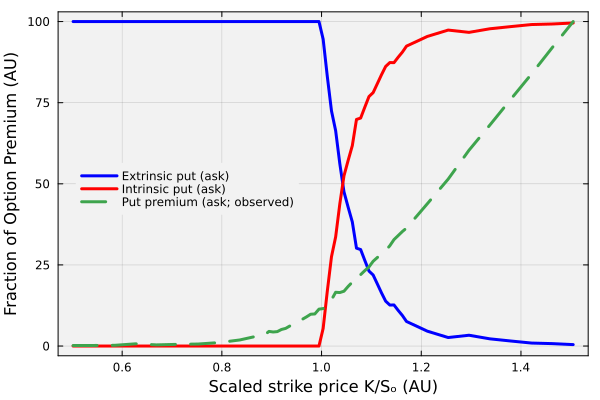

In [42]:
let
    plot(put_dataframe[:,:scaled_K], put_dataframe[:,:fraction_extrinsic_ask], c=:blue, lw=3, label="Extrinsic put (ask)", legend=:left, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(put_dataframe[:,:scaled_K], put_dataframe[:,:fraction_intrinsic_ask], c=:red, lw=3, label="Intrinsic put (ask)")
    plot!(put_dataframe[:,:scaled_K], 100*(put_dataframe[:,:premium_ask]/(maximum(put_dataframe[:,:premium_ask]))), lw=3, ls=:dash, label="Put premium (ask; observed)")
    xlabel!("Scaled strike price K/Sₒ (AU)", fontsize=18)
    ylabel!("Fraction of Option Premium (AU)", fontsize=18)
end

## Task 2: Compute the Intrinsic and Extrinsic values of American call contacts
In this task, we will compute the intrinsic and extrinsic values of an `AMD` call contract with `DTE` days to expiration (where `DTE` was specified above) using our market dataset. We'll show that the intrinsic and extrinsic values change as a function of the scaled strike price $K/S_{\circ}$. For a `call` contract:
* When $K/S_{\circ}\leq{1}$, the contract's intrinsic value becomes maximum, and the extrinsic value decays to zero. The premium observed in the marketplace in this regime is comprised of an increasing fraction of intrinsic value. In other words, if the `call` contract were exercised in this regime, the contract owner would have a non-negative payoff. 
* When $K/S_{\circ}>{1}$, the premium observed in the marketplace is solely extrinsic value, i.e., the contract has a zero-payoff if exercised. However, buyers are willing to pay a non-zero premium for a seemingly worthless contract because they believe market conditions will change such that $K/S(T)<1$ at some `T` in the future (at which point the contract will no longer be worthless if exercised).

Let's start to explore these scenarios by selecting the `DTE` contracts in the `list_of_call_options_chains::Dict{Int64, DataFrame}` variable, which we'll store in the `tmp_call_contract_list::DataFrame` variable. Each row in `tmp_call_contract_list::DataFrame` corresponds to a different `call` contract with the same days to expiration `DTE` value but different strike prices $K$.

In [21]:
tmp_call_contract_list = list_of_call_options_chains[DTE]

Row,underlying,strike,type,bid,ask,midpoint,bid_size,ask_size
,Float64,Float64,String,Float64,Float64,Float64,Int64,Int64
1,119.62,180.0,call,0.16,0.41,0.285,49,52
2,119.62,175.0,call,0.2,0.46,0.33,1,1
3,119.62,170.0,call,0.42,0.55,0.485,1,333
4,119.62,165.0,call,0.52,0.68,0.6,1,2
5,119.62,160.0,call,0.6,0.78,0.69,2,5
6,119.62,155.0,call,0.67,1.06,0.865,2,272
7,119.62,150.0,call,1.13,1.16,1.145,3,1
8,119.62,145.0,call,1.41,1.72,1.565,2,14
9,119.62,140.0,call,2.01,2.34,2.175,1,10


Next, for each contract in `tmp_call_contract_list::DataFrame,` we compute the payoff if we exercised the contract now, i.e., the intrinsic value and the extrinsic value (observed premium - intrinsic value) for each strike price in our list of contracts (which has dimension `number_of_call_contracts::Int64`). 
* We store the intrinsic, extrinsic et al. data in the `call_data_dictionary::Dict{Float64, NamedTuple}` dictionary, where the keys of this dictionary are strike prices $K$, and the values are a collection of various data associated with each contract.
* We process each contract (row) in the `tmp_call_contract_list::DataFrame` using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for). During each iteration of the loop, we access [data from the `tmp_contract_list::DataFrame` using the index and the column name](https://dataframes.juliadata.org/stable/man/comparisons/#Accessing-data). We then create [an instance of the `MyAmericanCallContractModel` model](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanCallContractModel) with the observed mid-point premium, strike price $K$ and other contract parameters, and [compute the payoff](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.payoff).
* Finally, we encode the intrinsic, extrinsic values and other data for each contract [in a `NamedTuple` instance](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) and store that in the `call_data_dictionary::Dict{Float64, NamedTuple}` dictionary, with the key being the strike price $K$.

In [23]:
number_of_call_contracts = nrow(tmp_call_contract_list);
call_data_dictionary = Dict{Float64, NamedTuple}();
for i ∈ 1:number_of_call_contracts
    K = tmp_call_contract_list[i,:strike];
    𝒫_ask = tmp_call_contract_list[i,:ask];
    𝒫_bid = tmp_call_contract_list[i,:bid];
    𝒫_mid = tmp_call_contract_list[i,:midpoint];
    Sₒ = tmp_call_contract_list[i,:underlying]

    # compute payoff (intrinsic) using short-cut syntax    
    payoff_array = build(MyAmericanCallContractModel, (
        K = K, sense = 1, copy = 1, DTE = (DTE*Δt), IV = 0.1, premium = 𝒫_mid)) |> model -> model([Sₒ]);

    # capture the data
    data = (
        intrinsic = payoff_array[1,end],
        extrinsic_bid = (𝒫_bid - payoff_array[1,end]),
        extrinsic_ask = (𝒫_ask - payoff_array[1,end]),
        extrinsic_mid = (𝒫_mid - payoff_array[1,end]),
        premium_bid = 𝒫_bid,
        premium_ask = 𝒫_ask,
        premium_mid = 𝒫_mid,
        underlying = Sₒ
    );
    call_data_dictionary[K] = data;
end

### Visualize
Given the data stored in the `call_data_dictionary::Dict{Float64, NamedTuple}` dictionary, let's visualize the extrinsic and intrinsic values for the `call` contracts as a function of the scaled strike price $K/S_{\circ}$. Collect data in the `call_dataframe::DataFrame` to make this plot using the code block below.
* For each contract in `call_data_dictionary::Dict{Float64, NamedTuple}` dictionary (where we iterate over the strike prices, i.e., the keys), we access the data from `call_data_dictionary::Dict{Float64, NamedTuple}` and compute several fields, e.g., the scaled strike price $K/S_{\circ}$, the fraction of the observed premium contained in the intrinsic and extrinsic values, etc. The data we will visualize is stored in the `call_dataframe::DataFrame` variable.

In [25]:
call_dataframe = let

    call_strike_price_array = keys(call_data_dictionary) |> collect |> sort; # how many strikes do we have?
    call_dataframe = DataFrame(); # initialize some storage
    counter = 0; # counter
    skip = 1; # skip constant
    
    # main loop
    for K ∈ call_strike_price_array

        if (mod(counter,skip) == 0)
            data = call_data_dictionary[K];
            row_df = (
                K = K, # strike
                scaled_K = (K/data.underlying), # scaled strike
                intrinsic = data.intrinsic, # intrinsic value
                extrinsic_bid = data.extrinsic_bid, # extrinsic of the bid
                extrinsic_ask = data.extrinsic_ask, # extrinsic of the ask
                premium_bid = data.premium_bid, # bid premium
                premium_ask = data.premium_ask, # ask premium
                fraction_extrinsic_ask = (data.extrinsic_ask/data.premium_ask)*100, # fraction of extrinsic for ask premium
                fraction_intrinsic_ask = (data.intrinsic/data.premium_ask)*100, # fraction of intrinsic for ask premium
            );
            push!(call_dataframe, row_df);
        end
        counter += 1;
    end
    call_dataframe;
end;

#### Summary
`Unhide` the code block below to see how we visualized the fraction of the `ask` price made up of the extrinsic and intrinsic values of `call` contract data as a function of $K/S_{\circ}$ stored in the `call_dataframe::DataFrame` variable.
* The observed scaled `call` premium (green line) decreases as $K/S_{\circ}\uparrow$ and reaches a maximum at some $K/S_{\circ}\ll{1}$ value (edge of the data). Thus, as $K/S_{\circ}\uparrow$, the payoff from exercising a `call` contract goes to zero. On the other hand, the condition $K/S_{\circ}\ll{1}$ implies $K\ll{S}_{\circ}$, which means the contract holder (following exercising the contract) buys shares at the strike $K$ and sells them at $S_{\circ}$.
* The extrinsic fraction (blue line) of the premium increases as $K/S_{\circ}\uparrow$, i.e., for a `call` contract, the extrinsic portion of the premium is _directly proportional_ to the scaled strike price $K/S_{\circ}$. Of course, the contract premium goes to zero as $K/S_{\circ}\rightarrow\infty$, thus, the actual total value of the contract is small in this regime.
* Conversely, the premium's intrinsic portion (red line) is _indirectly proportional_ to the scaled strike price $K/S_{\circ}$. Thus, as $K/S_{\circ}\downarrow$, the intrinsic value of the contract increases.

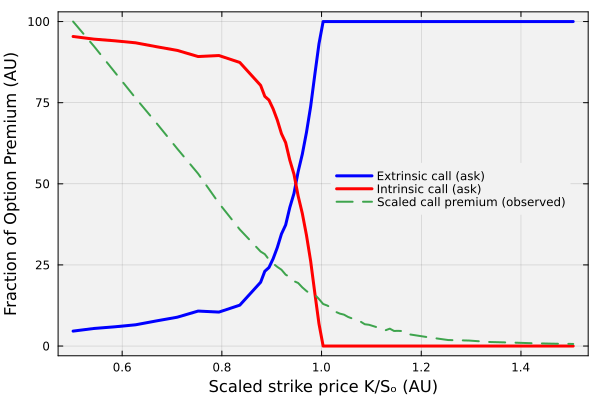

In [27]:
let
    plot(call_dataframe[:,:scaled_K], call_dataframe[:,:fraction_extrinsic_ask], c=:blue, lw=3, label="Extrinsic call (ask)", legend=:left, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(call_dataframe[:,:scaled_K], call_dataframe[:,:fraction_intrinsic_ask], c=:red, lw=3, label="Intrinsic call (ask)")
    plot!(call_dataframe[:,:scaled_K], 100*(call_dataframe[:,:premium_ask]/(maximum(call_dataframe[:,:premium_ask]))), lw=2, ls=:dash,
        label="Scaled call premium (observed)", legend=:right)
    xlabel!("Scaled strike price K/Sₒ (AU)", fontsize=18)
    ylabel!("Fraction of Option Premium (AU)", fontsize=18)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.